In [1]:
#pip install "pybamm[plot,cite]" -q    # install PyBaMM if it is not installed
import pybamm
import matplotlib.pyplot as plt

PyBaMM can collect usage data and send it to the PyBaMM team to help us improve the software.
We do not collect any sensitive information such as models, parameters, or simulation results - only information on which parts of the code are being used and how frequently.
This is entirely optional and does not impact the functionality of PyBaMM.
For more information, see https://docs.pybamm.org/en/latest/source/user_guide/index.html#telemetry

Timeout reached. Defaulting to not enabling telemetry.


In [2]:
model = pybamm.lithium_ion.DFN(
    {
        "SEI": "solvent-diffusion limited",
        "SEI porosity change": "true",
        "lithium plating": "partially reversible",
        "lithium plating porosity change": "true",  # alias for "SEI porosity change"
        "particle mechanics": ("swelling and cracking", "swelling only"),
        "SEI on cracks": "true",
        "loss of active material": "stress-driven",
    }
)

In [3]:
param = pybamm.ParameterValues("OKane2022")
var_pts = {
    "x_n": 5,  # negative electrode
    "x_s": 5,  # separator
    "x_p": 5,  # positive electrode
    "r_n": 30,  # negative particle
    "r_p": 30,  # positive particle
}

In [25]:
cycle_number = 1000
exp = pybamm.Experiment(
    [
        "Hold at 4.2 V until C/100 (5 minute period)",
        "Rest for 4 hours (5 minute period)",
        "Discharge at 0.1C until 0 V (5 minute period)",  # initial capacity check
        "Charge at 0.3C until 4.2 V (5 minute period)",
        "Hold at 4.2 V until C/100 (5 minute period)",
    ]
    + [
        (
            "Discharge at 1C until 0 V (1 minute period)",  # ageing cycles
            "Charge at 0.3C until 4.2 V (5 minute period)",
            "Hold at 4.2 V until C/100 (5 minute period)",
        )
    ]
    * cycle_number
    + ["Discharge at 0.1C until 2.5 V (5 minute period)"],  # final capacity check
)
solver = pybamm.IDAKLUSolver()
sim = pybamm.Simulation(
    model, parameter_values=param, experiment=exp, solver=solver, var_pts=var_pts
)
sol = sim.solve()

2025-03-24 15:52:03.238 - [WARNING] callbacks.on_experiment_infeasible_event(252): 

	Experiment is infeasible: 'event: Minimum voltage [V]' was triggered during 'Discharge at 0.1C until 0 V (5 minute period)'. The returned solution only contains up to step 1 of cycle 3. 


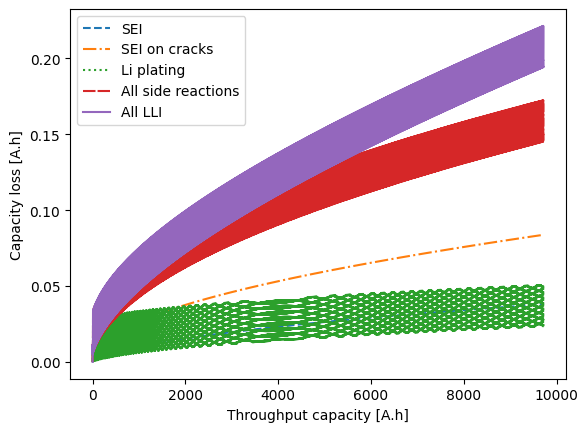

In [22]:
Qt = sol["Throughput capacity [A.h]"].entries
Q_SEI = sol["Loss of capacity to negative SEI [A.h]"].entries
Q_SEI_cr = sol["Loss of capacity to negative SEI on cracks [A.h]"].entries
Q_plating = sol["Loss of capacity to negative lithium plating [A.h]"].entries
Q_side = sol["Total capacity lost to side reactions [A.h]"].entries
Q_LLI = (
    sol["Total lithium lost [mol]"].entries * 96485.3 / 3600
)  # convert from mol to A.h
plt.figure()
plt.plot(Qt, Q_SEI, label="SEI", linestyle="dashed")
plt.plot(Qt, Q_SEI_cr, label="SEI on cracks", linestyle="dashdot")
plt.plot(Qt, Q_plating, label="Li plating", linestyle="dotted")
plt.plot(Qt, Q_side, label="All side reactions", linestyle=(0, (6, 1)))
plt.plot(Qt, Q_LLI, label="All LLI")
plt.xlabel("Throughput capacity [A.h]")
plt.ylabel("Capacity loss [A.h]")
plt.legend()
plt.show()

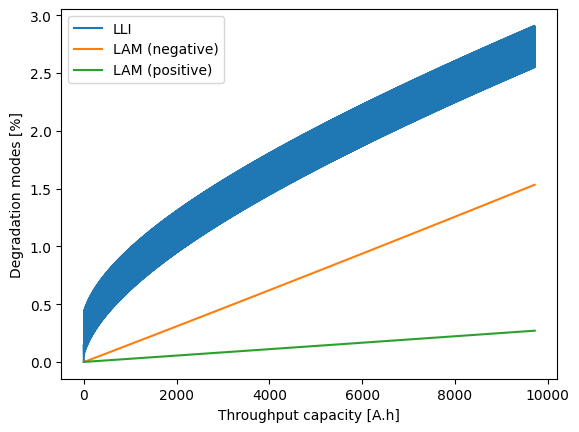

In [23]:
Qt = sol["Throughput capacity [A.h]"].entries
LLI = sol["Loss of lithium inventory [%]"].entries
LAM_neg = sol["Loss of active material in negative electrode [%]"].entries
LAM_pos = sol["Loss of active material in positive electrode [%]"].entries
plt.figure()
plt.plot(Qt, LLI, label="LLI")
plt.plot(Qt, LAM_neg, label="LAM (negative)")
plt.plot(Qt, LAM_pos, label="LAM (positive)")
plt.xlabel("Throughput capacity [A.h]")
plt.ylabel("Degradation modes [%]")
plt.legend()
plt.show()

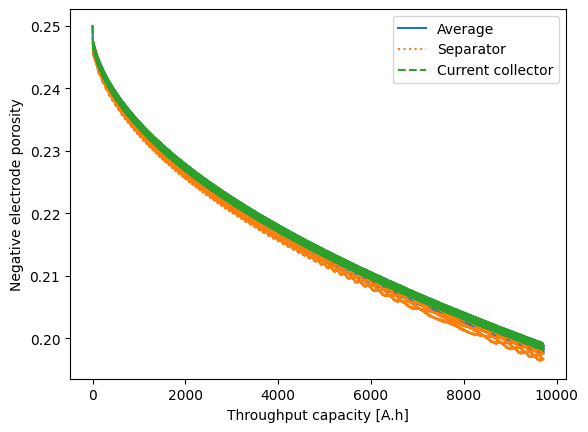

In [24]:
eps_neg_avg = sol["X-averaged negative electrode porosity"].entries
eps_neg_sep = sol["Negative electrode porosity"].entries[-1, :]
eps_neg_CC = sol["Negative electrode porosity"].entries[0, :]
plt.figure()
plt.plot(Qt, eps_neg_avg, label="Average")
plt.plot(Qt, eps_neg_sep, label="Separator", linestyle="dotted")
plt.plot(Qt, eps_neg_CC, label="Current collector", linestyle="dashed")
plt.xlabel("Throughput capacity [A.h]")
plt.ylabel("Negative electrode porosity")
plt.legend()
plt.show()